### 네이버 영화 평점 리뷰 데이터 노트북

#### 읽어오기

In [1]:
import pandas as pd

train = pd.read_csv('data/ratings_train.txt', sep='\t')
test = pd.read_csv('data/ratings_test.txt', sep='\t')

# 필요없는 열은 drop
train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

#### Null 값 제거하기

In [2]:
# null 개수 확인
print(f'trainset null 개수:\n{train.isnull().sum()}\n')
print(f'testset null 개수:\n{test.isnull().sum()}')

trainset null 개수:
document    5
label       0
dtype: int64

testset null 개수:
document    3
label       0
dtype: int64


In [3]:
train.dropna(inplace=True)
test.dropna(inplace=True)

#### 중복 제거하기

In [4]:
print(f'중복 제거 전 train length: {len(train)}')
train.drop_duplicates(subset=['document'], inplace=True, ignore_index=True)
print(f'중복 제거 후 train length: {len(train)}\n')
print(f'중복 제거 전 test length: {len(test)}')
test.drop_duplicates(subset=['document'], inplace=True, ignore_index=True)
print(f'중복 제거 후 test length: {len(test)}\n')

중복 제거 전 train length: 149995
중복 제거 후 train length: 146182

중복 제거 전 test length: 49997
중복 제거 후 test length: 49157



#### 정규표현식으로 한국어만 남기기

In [5]:
import re
from tqdm import tqdm

def removing_non_korean(df):
    for idx, row in tqdm(df.iterrows(), desc='removing_non_korean', total=len(df)):
        new_doc = re.sub('[^가-힣]', '', row['document']).strip()
        df.loc[idx, 'document'] = new_doc
    return df

In [6]:
train = removing_non_korean(train)
test = removing_non_korean(test)

removing_non_korean: 100%|██████████| 49157/49157 [00:05<00:00, 8475.00it/s]


#### 조사 제거하기

In [7]:
tags = ['JK', 'JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX', 'JC', 'EP', 'EF', 'EC', 'ETN', 'ETM']

In [8]:
from konlpy.tag import Mecab

m = Mecab()

def remove_josa_mecab(df, tags):
    for idx, row in tqdm(df.iterrows(), desc='removing josa', total=len(df)):
        josa_removed = [x[0] for x in m.pos(row['document']) if x[1] not in tags]
        df.loc[idx, 'document'] = ' '.join(josa_removed)
    return df

train_mecab = remove_josa_mecab(train, tags)
test_mecab = remove_josa_mecab(test, tags)

removing josa: 100%|██████████| 49157/49157 [00:13<00:00, 3656.56it/s]


In [9]:
from konlpy.tag import Komoran

k = Komoran()

def remove_josa_komoran(df, tags):
    for idx, row in tqdm(df.iterrows(), desc='removing josa', total=len(df)):
        josa_removed = [x[0] for x in k.pos(row['document']) if x[1] not in tags]
        df.loc[idx, 'document'] = ' '.join(josa_removed)
    return df

train_komoran = remove_josa_komoran(train, tags)
test_komoran = remove_josa_komoran(test, tags)

removing josa: 100%|██████████| 49157/49157 [00:31<00:00, 1577.20it/s]


#### label 분포 확인하기

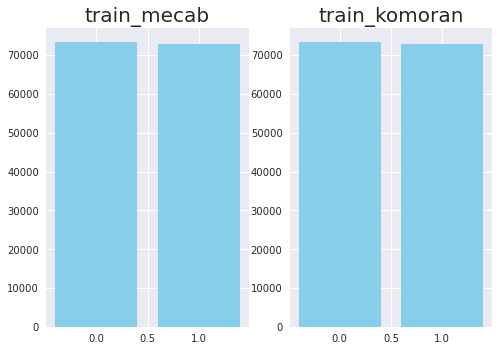

In [10]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

train_mecab_vlcnt = train_mecab['label'].value_counts().reset_index()
train_komoran_vlcnt = train_komoran['label'].value_counts().reset_index()

plt.subplot(1, 2, 1)
plt.title('train_mecab', fontsize=20)
plt.bar(train_mecab_vlcnt['index'], train_mecab_vlcnt['label'], color='skyblue')

plt.subplot(1, 2, 2)
plt.title('train_komoran', fontsize=20)
plt.bar(train_komoran_vlcnt['index'], train_komoran_vlcnt['label'], color='skyblue')

plt.show()